# Mini-project1 - Image Binary Classification with Pactch Camelyon

목표
- Patch Camelyon dataset을 이용해 림프절 이미지에서 metastatic tissue가 존재하는지 80%이상의 accuracy로 판단하는 classifier 설계하고 학습시키기

## 사용할 라이브러리 import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
#
# import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' ## 이거 안쓰면 GPU메모리 확 잡아먹어 알아서 GPU메모리 선점해
#

## 학습시키기 위해 메모리 분배

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))  ### GPU 메모리 소모량 감소 OOM발생해서 처리

## 이번에 사용할 데이터셋은 Pactch Camelyon이다. 

In [3]:
###데이터셋 준비
(train_ds, validation_ds, test_ds) = tfds.load(name='patch_camelyon',
                                               shuffle_files=True,
                                               as_supervised=True,
                                               split=['train', 'validation', 'test'],
                                               batch_size=64)  ## as_supervised를 쓰면 tuple형 반환

In [4]:
### 데이터 nomalize
def Normalization(images, labels):
    images = tf.cast(images, tf.float32) / 255.
    return [images, labels]


train_ds = train_ds.map(Normalization).shuffle(1000)
validation_ds = validation_ds.map(Normalization)
test_ds = test_ds.map(Normalization)

데이터셋을 shuffle하고 데이터를 dict 형식으로 받는다. 학습을 위한 train, 검증을 위한 validation, 테스트를 위한 test셋으로 나눠서 받는다.
그리고 각각의 데이터셋을 학습속도 향상과 Local optimum을 을 방지하도록 Normalization한다.

In [5]:
validation_ds

<MapDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.float32, tf.int64)>

In [6]:
test_ds

<MapDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.float32, tf.int64)>

In [7]:
model = Sequential()
model.add(InputLayer(input_shape=(96, 96, 3))) 
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

### 기본적인 CNN모델을 사용하였다. feature extractor로 convolution layer와 pooling layer와 성능 향상, 오버피팅방지를 위해 batch nomalization을 사용하였고 classifier로 fully connected layer를 사용하였다

## optimizer='adam', loss=SparseCategoricalCrossentropy, metrics=accuracy

옵티마이저는 ADAM과 아래 SGD를 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [8]:
model.compile(optimizer='adam', 
              loss=SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

## validation

In [19]:
print("Fit model on training data")
history = model.fit(
    train_ds,
#     batch_size=32,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=validation_ds
)

Fit model on training data
Epoch 1/10
4096/4096 [==============================] - 86s 21ms/step - loss: 0.0076 - accuracy: 0.9971 - val_loss: 1.9036 - val_accuracy: 0.8462
Epoch 2/10
4096/4096 [==============================] - 76s 19ms/step - loss: 0.0086 - accuracy: 0.9969 - val_loss: 2.4558 - val_accuracy: 0.8167
Epoch 3/10
4096/4096 [==============================] - 77s 19ms/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 2.5029 - val_accuracy: 0.8334
Epoch 4/10
4096/4096 [==============================] - 75s 18ms/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 1.9585 - val_accuracy: 0.8490
Epoch 5/10
4096/4096 [==============================] - 79s 19ms/step - loss: 0.0076 - accuracy: 0.9971 - val_loss: 2.2865 - val_accuracy: 0.8430
Epoch 6/10
4096/4096 [==============================] - 76s 19ms/step - loss: 0.0071 - accuracy: 0.9973 - val_loss: 2.4527 - val_accuracy: 0.8270
Epoch 7/10
4096/4096 [==============================] - 75s 18ms/step - loss: 0.0076 - accuracy: 

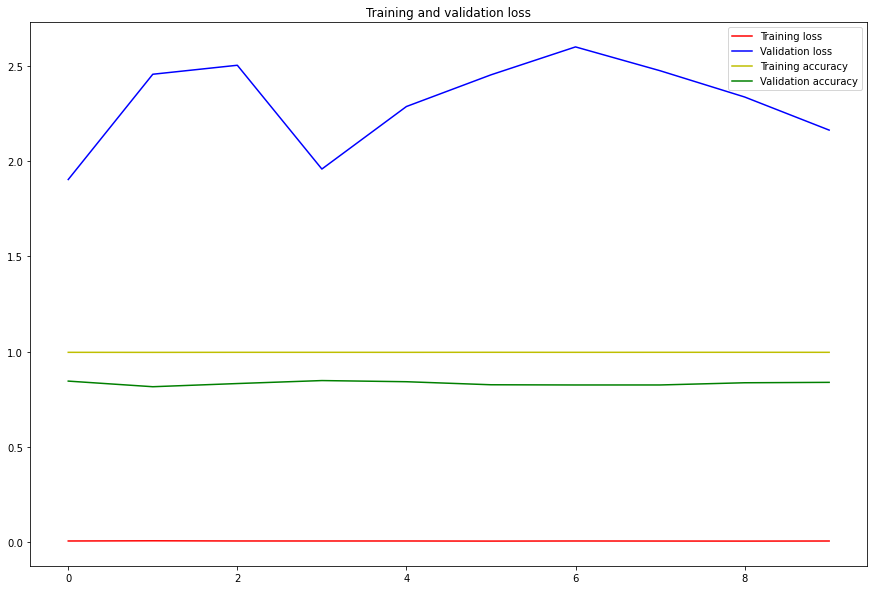

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.plot(epochs, accuracy, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

30EPOCHS를 돌렸을때 오버피팅이 심하게 일어나서 성능이 괜찮은 10epochs를 사용하겠다. 아래는 30epochs돌렸을때 사진이다

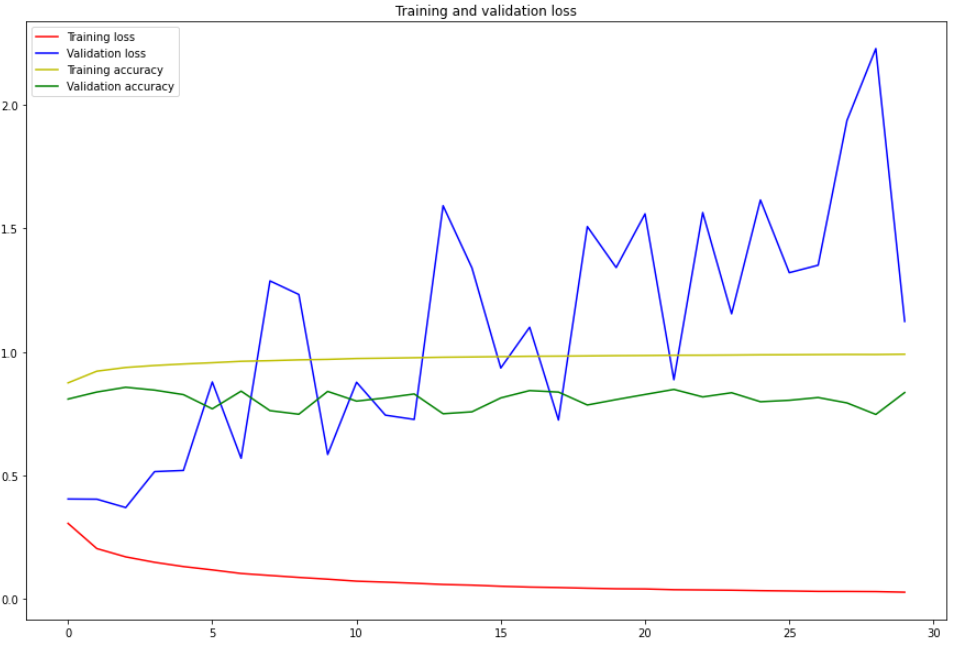

# test

In [21]:
print("Fit model on test data")
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(test_acc)

Fit model on test data
0.79782104


### test step 결과
accuracy score가 79.8이나오고 있다. adam optimizer 사용하니 79퍼가 나온다 밑에 SGD를 사용해보자

## optimizer='sgd', loss=SparseCategoricalCrossentropy, metrics=accuracy

옵티마이저는 SGD와 위의 ADAM을 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [12]:
model.compile(optimizer='sgd', 
              loss=SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [13]:
print("Fit model on training data")
history = model.fit(
    train_ds,
#     batch_size=32,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=validation_ds
)

Fit model on training data
Epoch 1/10
4096/4096 [==============================] - 83s 20ms/step - loss: 0.0166 - accuracy: 0.9940 - val_loss: 1.4976 - val_accuracy: 0.8419
Epoch 2/10
4096/4096 [==============================] - 78s 19ms/step - loss: 0.0137 - accuracy: 0.9950 - val_loss: 1.6935 - val_accuracy: 0.8457
Epoch 3/10
4096/4096 [==============================] - 81s 20ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 1.5734 - val_accuracy: 0.8404
Epoch 4/10
4096/4096 [==============================] - 75s 18ms/step - loss: 0.0119 - accuracy: 0.9956 - val_loss: 1.6253 - val_accuracy: 0.8414
Epoch 5/10
4096/4096 [==============================] - 76s 19ms/step - loss: 0.0110 - accuracy: 0.9959 - val_loss: 2.3721 - val_accuracy: 0.8103
Epoch 6/10
4096/4096 [==============================] - 79s 19ms/step - loss: 0.0100 - accuracy: 0.9961 - val_loss: 1.7423 - val_accuracy: 0.8403
Epoch 7/10
4096/4096 [==============================] - 77s 19ms/step - loss: 0.0103 - accuracy: 

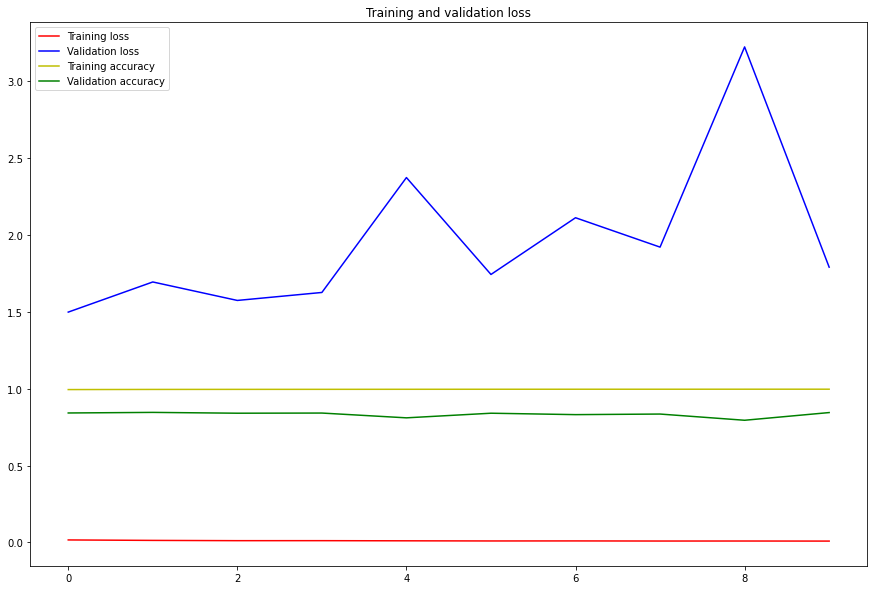

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.plot(epochs, accuracy, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

30EPOCHS로 돌리니 성능이 떨어지는걸 확인할수 있다. 오버피팅이 발생한것같다.
최적의 10 EPOCHS시 가장 좋은 성능을 나타냄으로 10EPOCHS로 해봐야겠다. 아래는 당시 그래프이다.

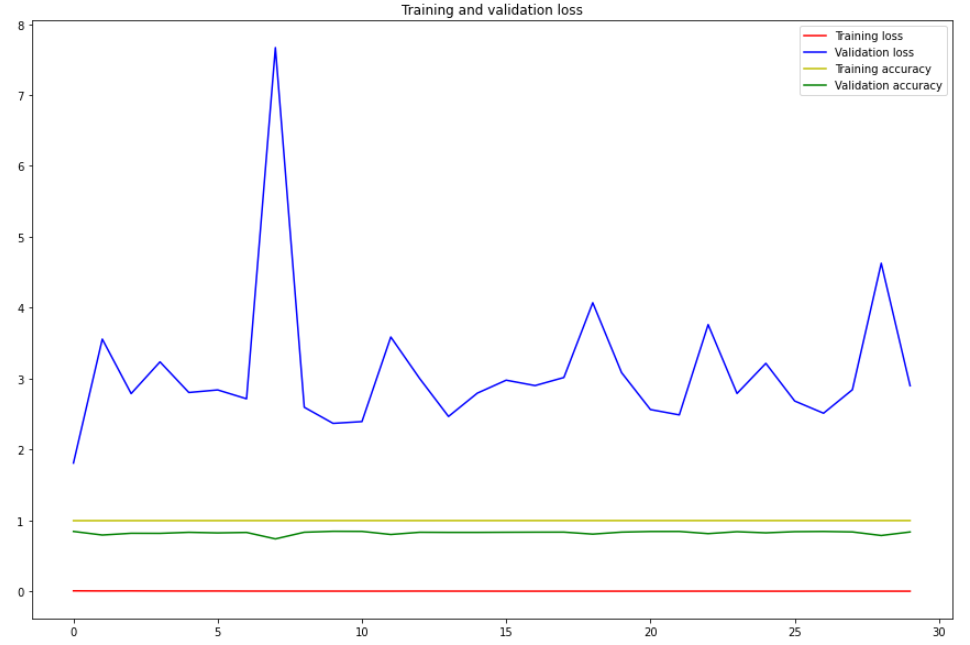

# test

In [15]:
print("Fit model on test data")
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(test_acc)

Fit model on test data
0.8006897


SGD를 사용하니 accuracy score가 80% accuracy가 나왔다.